# Attempt to Model Velocity Dependence _with DNNs_
Retry the problem form the previous notebook

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.keras import build_fn as build_dense
from glob import glob
from tqdm import tqdm_notebook as tqdm

from keras.layers import Dense, Activation, Input
from keras.layers import Concatenate, Multiply, Add
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle as pkl
import numpy as np
import pandas as pd
import os

Using TensorFlow backend.


## Load in Data
Read in the random trajectories

In [2]:
data = pd.read_pickle(os.path.join('data', 'random_traj.pkl'))

In [46]:
channel_data = pd.read_pickle(os.path.join('data', 'random_traj.pkl'))

In [47]:
with open('featurizer.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

Get the features

In [48]:
X_cols = featurizer.feature_labels()

In [49]:
X_cols_novel = list(X_cols)
X_cols_novel.remove("velocity_mag")

In [6]:
X_cols_vel = ["velocity_mag"]

In [7]:
y_col = 'force'

## Create Functions for Building Models
Create functions for building a Keras model

In [8]:
input_shape = (len(X_cols_novel),)
v_input_shape = (len(X_cols_vel),)
layers = (input_shape[0],16,12,8,4,3)
v_layers = (v_input_shape[0],3,3)
m_layers = (layers[-1],3)
activation = 'elu'

In [9]:
optimizer_options = {
    'loss': 'mean_absolute_error', 
    'optimizer': Adam(lr=0.0005),
    'metrics': ['mean_absolute_error']
}

In [10]:
callbacks = [EarlyStopping(monitor='mean_absolute_error', patience=100, verbose=0, mode='auto'),
             ReduceLROnPlateau('mean_absolute_error')]

### Standard Dense Model
Just treat all layers equally

In [11]:
model = build_dense(len(X_cols), layers, activation=activation, use_linear_block=False,
                   optimizer_options=optimizer_options)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 19)                76        
_________________________________________________________________
dense_1 (Dense)              (None, 18)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                304       
_________________________________________________________________
dense_3 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
__________

### Model with Velocity Separate
Train two inputs: One based on the features, another based on velocity

In [50]:
def build_velocity_merge_model(layers, v_layers, m_layers, input_shape, v_input_shape, activation, merge_type=Multiply, optimizer='adam', loss='mean_absolute_error', summary=False):
    """Create a model where the velocity input is treated separately, and later merged in with the main model
    
    Args:
        layers ([int]) - layers for the main inputs
        v_layers ([int]) - layers for the velocity input
        m_layers ([int]]) - layers after the two input networks are merged
        input_shape ([int]) - Shape of the main inputs
        v_input_shape ([int]) - Shape of the velocity inputs
        activation (str) - Type of the activation layer
        merge_type (Layer) - Method used to combine the layers
        optimizer (str) - Optimization method
        loss (str) - Loss metric
        summary (bool) - Whether to print summary
    Returns:
        (Model): Keras model
    """
    
    # Make the network for the main features
    main_input = Input(shape=input_shape)
    l = Dense(layers[0], activation=activation)(main_input)
    for layer in layers[1:]:
        l = (Dense(layer, activation=activation))(l)
        
    # Make the network for both
    v_input = Input(shape=v_input_shape)
    r = Dense(v_layers[0], activation=activation)(v_input)
    for v_layer in v_layers[1:]:
        r = (Dense(v_layer, activation=activation))(r)
        
    # Multiple them together
    m = merge_type()([l, r])
    
    # Make the post-merge network
    for m_layer in m_layers:
        m = (Dense(m_layer, activation=activation))(m)
        
    output = Dense(1, activation='linear')(m)
    
    model = Model(inputs=[main_input, v_input], 
                         outputs=[output])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    if summary:
        model.summary()
    return model

Build an initial model

In [14]:
merge_model = build_velocity_merge_model(layers, v_layers, m_layers, input_shape, v_input_shape, activation)

In [15]:
merge_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 18)           0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 18)           342         input_1[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 16)           304         dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 12)           204         dense_8[0][0]                    
__________________________________________________________________________________________________
input_2 (I

## Test on the Whole Dataset
Fit the model on the whole dataset

In [16]:
def fit_on_whole_dataset(model, callbacks=[], epochs=1, split_v=False):
    """Test train a model on the whole dataset
    
    Args:
        model (Model): Model to be trained 
        callbacks ([List]): List of callbacks used during training
        epochs (int): Maximum number of epochs for training
    Returns:
        history - history from the fit
    """

    # Train the model
    if split_v:
        return model.fit([data[X_cols_novel], data[X_cols_vel]], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        return model.fit(data[X_cols], data[y_col], epochs=epochs, callbacks=callbacks, verbose=0)

Fit the whole model

In [17]:
%%time
dense_history = fit_on_whole_dataset(model, callbacks, 1000, False)

CPU times: user 34min 28s, sys: 35min 52s, total: 1h 10min 20s
Wall time: 12min 17s


In [18]:
%%time
merge_history = fit_on_whole_dataset(merge_model, callbacks, 1000, True)

CPU times: user 18min 35s, sys: 2min 1s, total: 20min 37s
Wall time: 14min 41s


Plot results

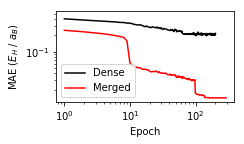

In [19]:
fig, ax = plt.subplots()

ax.loglog(dense_history.epoch, dense_history.history['mean_absolute_error'], 'k', label='Dense')
ax.loglog(merge_history.epoch, merge_history.history['mean_absolute_error'], 'r', label='Merged')

ax.set_ylabel('MAE ($E_H$ / $a_B$)')
ax.set_xlabel('Epoch')

ax.legend()

fig.set_size_inches(3.5, 2.1)
fig.tight_layout()

## Evaluate Model Performance
Get the performance of the model on the whole dataset

In [51]:
def plot_performance(model, split_v):
    """Plot the performance of the model on multiple velocities"""

    # Evaluate on the whole dataset
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_novel], data[X_cols_vel]])
    else:
        data['force_fit'] = model.predict(data[X_cols])

    # Plot results
    fig, ax = plt.subplots(1, 3)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        # Store the velocity
        velocity.append(group['velocity_mag'].mean())
        
        # Plot the performance on a segment of the dataset
        label = 'v={:.1f}'.format(group['velocity_mag'].mean())
        
        for a in ax[:2]:
            my_line, = a.plot(group['displacement'], group['force'], linestyle='--',
                                  label=label)

            a.plot(group['displacement'], group['force_fit'].tolist(), color=my_line.get_color(), lw=3, alpha=0.5)
            
            a.set_xlabel('Displacement (a.u.)')
            a.set_ylabel('Force ($E_H / a_B$)')
        
        # Select a certain subset
        ax[0].set_xlim(40, 60)
        #ax[0].set_ylim(-0.3, 0.7)
        ax[0].set_yscale('symlog')
        #ax[0].legend(ncol=2)
        
        # Select a certain subset
        ax[1].set_xlim(52, 65)
        ax[1].set_ylim(-0.5, 0.9)
        #ax[1].legend(ncol=2)
        
        # Store the stopping pwoers
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[2].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[2].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[2].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[2].set_xlabel('Velocity (au.)')
    ax[2].set_ylim(0, max(ax[2].get_ylim()))
    ax[2].set_xlim(0, 4.2)
    ax[2].legend()
    
    fig.set_size_inches(8, 2.5)
    fig.tight_layout()
    
    return fig, ax

Plot the dense model

(<matplotlib.figure.Figure at 0x7f3da3ddbe80>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e59d428d0>,
       dtype=object))

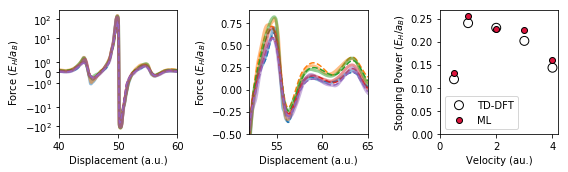

In [52]:
plot_performance(model, False)

(<matplotlib.figure.Figure at 0x7f3da3b0e6a0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3da362c048>,
       dtype=object))

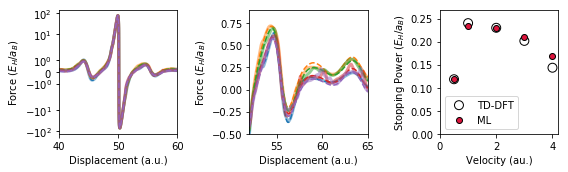

In [53]:
plot_performance(merge_model, True)

*Finding*: The model does interpolate between different velocities decently

## Leave-one-velocity-out Cross-Validation
Can we interpolate between different velocities?

Andre uses 6 $a_B$

In [ ]:
velocity_strs = set(data['velocity_str'])

In [ ]:
train_sets = []
test_sets = []

for vel in velocity_strs:
    train_sets.append(data.query("velocity_str != '{}'".format(vel)))
    test_sets.append(data.query("velocity_str == '{}'".format(vel)))

In [ ]:
def show_prediction_scatter(test_set):
    dirname = test_set['directory'].iloc[0]
    plt.figure()
    plt.title('{} Force Preds'.format(dirname))
    plt.xlabel('Actual Force')
    plt.ylabel('Prediction')
    plt.scatter(test_set['force'], test_set['force_fit'])
    plt.show()

In [ ]:
def fit_and_cross_test(model, train_set, test_set, callbacks=[], epochs=1, split_v=False, verbose=0):

    if split_v:
        try:
            model.fit([train_set[X_cols_orig], train_set[V_cols]], train_set[y_col], epochs=epochs, callbacks=callbacks, verbose=verbose)
        except Exception as e:
            print(e)
            model.fit([train_set[X_cols_orig], train_set[V_cols]], train_set[y_col], verbose=verbose)
        
    else:
        try:
            model.fit(train_set[X_cols], train_set[y_col], epochs=epochs, callbacks=callbacks, verbose=verbose)
        except Exception as e:
            print(e)
            model.fit(train_set[X_cols], train_set[y_col], verbose=verbose)
            
    if split_v:
        data['force_fit'] = model.predict([data[X_cols_orig], data[V_cols]])
        test_set['force_fit'] = model.predict([test_set[X_cols_orig], test_set[V_cols]])
    else:
        data['force_fit'] = model.predict(data[X_cols])
        test_set['force_fit'] = model.predict(test_set[X_cols])
        

    fig, ax = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        velocity.append(float(gid[-3:]))
        
        # Plot the performance
        my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

        if split_v:
            ax[0].plot(group['displacement'], model.predict([group[X_cols_orig], group[V_cols]]), color=my_line.get_color(), lw=5, alpha=0.3)
        else:
            ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)
        
        ax[0].set_xlim(30, 40)
        ax[0].set_ylim(-0.3, 0.7)
        ax[0].legend(ncol=2)

        ax[0].set_xlabel('Displacement (a.u.)')
        ax[0].set_ylabel('Force ($E_H / a_B$)')
        
        # Plot the mean velocity
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[1].set_xlabel('Velocity (au.)')
    ax[1].set_ylim(0, max(ax[1].get_ylim()))
    ax[1].set_xlim(0, 4.2)
    ax[1].legend()
    
    fig.tight_layout()
    
    return fig, ax

In [ ]:
input_shape = (21,)
layers = (input_shape[0],18,16,12,8,4)
activation = 'selu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 250
i = 3

callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto'),
            EarlyStopping(monitor='mean_absolute_error', patience=15, verbose=0, mode='auto')]

fit_and_cross_test( build_dense_model(layers, input_shape, activation), train_sets[i], test_sets[i],
                   callbacks=callbacks, epochs=epochs, verbose=0)
show_prediction_scatter(test_sets[i])

In [ ]:
input_shape = (21,)
layers = (input_shape[0],18,16,12,8,4)
activation = 'selu'
#optimizer = 'rmsprop'
#loss = 'mean_squared_error' 
epochs = 250
#i = 0



for i in range(2, len(train_sets)):
    callbacks = [ReduceLROnPlateau(monitor='mean_absolute_error', patience=5, verbose=1, factor=0.5, mode='auto'),
            EarlyStopping(monitor='mean_absolute_error', patience=15, verbose=1, mode='auto')]
    
    fit_and_cross_test( build_dense_model(layers, input_shape, activation), train_sets[i], test_sets[i],
                   callbacks=callbacks, epochs=epochs, verbose=1)
    show_prediction_scatter(test_sets[i])